# plot O2 solubility function

In [6]:
%matplotlib inline
from config_calc import *

import matplotlib.pyplot as plt
plt.rcParams['mathtext.default']='regular'

import solubility

dataroot = '/glade/p/ncgd0033/obs'
#dataroot = '/project/oce/mclong'

In [34]:
woapth = os.path.join(dataroot,'woa2013v2/1x1d')

woa = {
    'O2': {'varname': 'o_an', 'file' : os.path.join(woapth,'woa13_all_o00_01.nc')},   
    'O2sat': {'varname': 'O_an', 'file': os.path.join(woapth,'woa13_all_O00_01.nc')},
    'AOU': {'varname': 'A_an', 'file' : os.path.join(woapth,'woa13_all_A00_01.nc')},    
    'TEMP' : {'varname': 't_an', 'file': os.path.join(woapth,'woa13_decav_t00_01v2.nc')},
    'SALT' : {'varname': 's_an', 'file': os.path.join(woapth,'woa13_decav_s00_01v2.nc')},
    'NO3' : {'varname': 'n_an', 'file': os.path.join(woapth,'woa13_all_n00_01.nc')},
    'PO4' : {'varname': 'p_an', 'file': os.path.join(woapth,'woa13_all_p00_01.nc')}}

ds = {}
for v,info in woa.items():   
    varname = info['varname']
    file_in = info['file']
    dsi = xr.open_dataset(file_in,decode_times=False)
    dsi = dsi.drop([k for k in dsi if k not in [varname,'lat','lon','depth','depth_bnds']])
    dsi = dsi.rename({varname:v})
    if ds:
        ds = xr.merge((ds,dsi))
    else:
        ds = dsi
         
ni = len(ds.lon)
nj = len(ds.lat)

mlperl_2_mmolm3 = 1.e6 / 1.e3 / 22.3916
for v in ['O2','AOU']:
    ds[v] = ds[v] * mlperl_2_mmolm3
    ds[v].attrs['units'] = 'mmol m$^{-3}$'
ds = ds.isel(time=0,depth=0)
ds

<xarray.Dataset>
Dimensions:     (lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
    depth       float32 0.0
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (nbounds) float32 0.0 2.5
    TEMP        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    PO4         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    O2sat       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    AOU         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    SALT        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    O2          (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    NO3         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...

In [35]:
mask_file_in = os.path.join(dataroot,'woa2013v2/1x1d/woa_region_mask.nc')
dsm = xr.open_dataset(mask_file_in)
dsm

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360, region: 5)
Coordinates:
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon             (lon) float64 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
Dimensions without coordinates: region
Data variables:
    area            (lat, lon) float64 1.079e+08 1.079e+08 1.079e+08 ...
    mask            (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    kmt             (lat, lon) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    REGION_MASK_3D  (region, lat, lon) float64 nan nan nan nan nan nan nan ...
    region_names    (region) |S14 'Global' 'Pacific' 'Atlantic' 'Indian' ...

In [36]:
ds = ds.where(dsm.REGION_MASK_3D[0,:,:]==1)   
ds

<xarray.Dataset>
Dimensions:     (lat: 180, lon: 360, nbounds: 2)
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 -84.5 -83.5 ...
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 -175.5 -174.5 ...
    depth       float32 0.0
Dimensions without coordinates: nbounds
Data variables:
    depth_bnds  (nbounds, lat, lon) float32 nan nan nan nan nan nan nan nan ...
    TEMP        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    PO4         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    O2sat       (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    AOU         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    SALT        (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    O2          (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...
    NO3         (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan ...

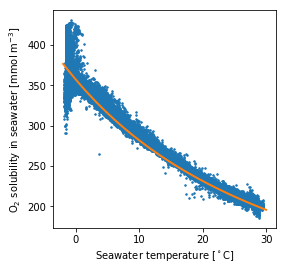

In [39]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)

S = 35.
T = np.arange(-2.,31.,1.)

#ds = ds.where(ds.TEMP >= T[0])
ax.plot(ds.TEMP.values.ravel(),ds.O2.values.ravel(),'.',markersize=3)

p = ax.plot(T,solubility.O2(S,T),'-',linewidth=2.)

ax.set_xlabel('Seawater temperature [$^\circ$C]')
ax.set_ylabel('O$_2$ solubility in seawater [mmol m$^{-3}$]')

#ax.set_xlim((T.min(),T.max()))
plt.savefig(os.path.join(diro['fig'],'o2sol-v-temp.pdf'),dpi=300,bbox_inches='tight')


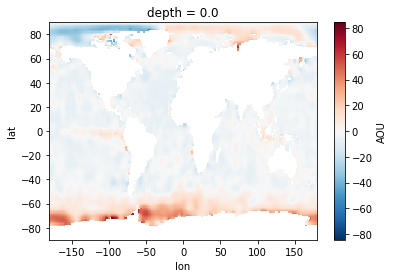

In [29]:
ds.AOU.plot()